In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
#Con esto podemos echar un vistazo a código HTML directamente en la Notebook
from IPython.display import HTML, display
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, r2_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, cross_val_score
from sklearn.feature_selection import rfe, SelectKBest, f_classif, f_regression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
%matplotlib inline

In [11]:
file = 'appointments2016.csv'
data = pd.read_csv(file)
data.shape

(110527, 116)

## BASELINE

In [12]:
baseline = 1 - data['No-show'].sum()/len(data['No-show'])
print(baseline)
print(1-baseline)
total_no_shows = data['No-show'].sum()
print(total_no_shows)
print(data.isnull().sum().sum())

0.798067440534892
0.20193255946510802
22319
0


In [13]:
features_to_ignore = ['DateAppointment','TimeScheduled', 'DateScheduled', 'AppointmentID',\
                      'PatientId', 'No-show', 'Neighborhood']
valid_features = [c for c in data.columns if c not in features_to_ignore]
len(valid_features)

109

In [14]:
## Order all the features by correlation
valid_features.append('No-show')
features_corr = data[valid_features].corr()['No-show'].apply(lambda x: abs(x)).sort_values(ascending=False)
valid_features.remove('No-show')
featuresCorr = features_corr.index[1:]
len(featuresCorr), len(features_corr)

(109, 110)

# GradientBoostClassifier

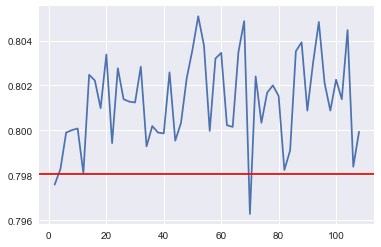

In [9]:
##GradientBoosting. Calculating number of features
llista = featuresCorr
initial_amount = 2
increases = 2
compte = []
accuracy_gbc2 = []
#X = data[valid_features]
#y = data['No-show']
    #intents = round(len(valid_features)/(len(valid_features)/(num_tries)))
for i in range(initial_amount, len(llista), increases):
    X = data[featuresCorr[0:i]]
    compte.append(i)
    y = data['No-show']
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.fit_transform(X_test)
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    model.score(X_test, y_test)
    predicted = model.predict(X_test)
    acc = accuracy_score(y_test, predicted)
    accuracy_gbc2.append(acc)
plt.plot(compte, accuracy_gbc2)
plt.axhline(baseline, c='r')

## Logistic Regression

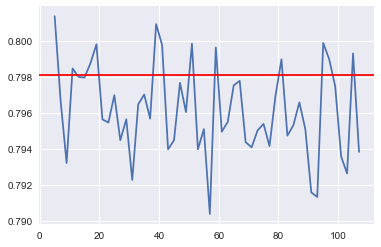

In [17]:
##LogisticRegression. Calculating number of features
llista = featuresCorr
initial_amount = 5
increases = 2
compte = []
accuracy_logreg = []

   
for i in range(initial_amount, len(llista), increases):
    llista = featuresCorr[0:i]
    compte.append(i)
    X = data[llista]
    y = data['No-show']
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.fit_transform(X_test)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    model.score(X_test, y_test)
    predicted = model.predict(X_test)
    acc = accuracy_score(y_test, predicted)
    accuracy_logreg.append(acc)
plt.plot(compte, accuracy_logreg)
plt.axhline(baseline, c='r')

In [48]:
with open('accuracy_logreg.pkl', 'wb') as picklefile:
    pickle.dump(accuracy_logreg, picklefile)

# TensorFlow

/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


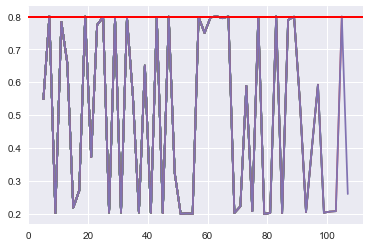

In [55]:
##TensorFlow. Calculating number of features
llista = featuresCorr
initial_amount = 5
increases = 2
compte = []
accuracy_tf = []
X = data[llista]
y = data['No-show']
#intents = round(len(valid_features)/(len(valid_features)/(num_tries)))

for i in range(initial_amount, len(llista), increases):
    
    colec = llista[0:i]
    X= data[colec]
    #Xk = X.iloc[:, select.get_support()]
    compte.append(i)
    y = data['No-show']
    y = y.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.fit_transform(X_test)
    
    tf.reset_default_graph()
    
    X= tf.placeholder(dtype=tf.float32, shape=(None, Xs_train.shape[1]), name='X')
    y= tf.placeholder(dtype=tf.float32, shape=(None), name='y')
    h1 = tf.layers.dense(X, 7, name='hidden1', activation=tf.nn.relu)
    h2 = tf.layers.dense(h1, 7, name='hidden2', activation=tf.nn.relu)
    #h3 = tf.layers.dense(h2, 30, name='hidden3', activation=tf.nn.relu)
    y_hat = tf.layers.dense(h2, 1, name='y_hat', activation=tf.nn.sigmoid)

    loss = tf.losses.log_loss(y, y_hat)
    optimizer = tf.train.AdamOptimizer(.01)
    training_op  = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        init.run()
        epoch = 10
        sess.run(training_op, feed_dict={X: Xs_train, y: y_train})

        predicted = sess.run(y_hat, feed_dict={X: X_test})

        predicted = (predicted >0.5).astype(int)

        acc = accuracy_score(y_test, predicted)
        accuracy_tf.append(acc)
     

    plt.plot(compte, accuracy_tf)
    plt.axhline(baseline, c='r')


In [57]:
with open('accuracy_tf.pkl', 'wb') as picklefile:
    pickle.dump(accuracy_tf, picklefile)

# Keras

/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Train on 82895 samples, validate on 27632 samples
Epoch 1/10
82895/82895 [==============================] - 9s 105us/step - loss: 0.4789 - acc: 0.7918 - val_loss: 0.4597 - val_acc: 0.8002
Epoch 2/10
82895/82895 [==============================] - 9s 107us/step - loss: 0.4586 - acc: 0.7994 - val_loss: 0.4568 - val_acc: 0.7998
Epoch 3/10
82895/82895 [==============================] - 9s 111us/step - loss: 0.4561 - acc: 0.7998 - val_loss: 0.4546 - val_acc: 0.8003
Epoch 4/10
82895/82895 [==============================] - 9s 111us/step - loss: 0.4543 - acc: 0.7995 - val_loss: 0.4537 - val_acc: 0.8001
Epoch 5/10
82895/82895 [==============================] - 9s 107us/step - loss: 0.4528 - acc: 0.8001 - val_loss: 0.4525 - val_acc: 0.8006
Epoch 6/10
82895/82895 [==============================] - 9s 106us/step - loss: 0.4515 - acc: 0.8000 - val_loss: 0.4524 - val_acc: 0.8000
Epoch 7/10
82895/82895 [==============================] - 9s 109us/step - loss: 0.4502 - acc: 0.7999 - val_loss: 0.4508 - 

Epoch 6/10
82895/82895 [==============================] - 10s 121us/step - loss: 0.4501 - acc: 0.8002 - val_loss: 0.4515 - val_acc: 0.7999
Epoch 7/10
82895/82895 [==============================] - 9s 112us/step - loss: 0.4490 - acc: 0.7991 - val_loss: 0.4508 - val_acc: 0.7993
Epoch 8/10
82895/82895 [==============================] - 9s 112us/step - loss: 0.4481 - acc: 0.7997 - val_loss: 0.4498 - val_acc: 0.8007
Epoch 9/10
82895/82895 [==============================] - 11s 130us/step - loss: 0.4471 - acc: 0.7999 - val_loss: 0.4489 - val_acc: 0.7998
Epoch 10/10
27632/27632 [==============================] - 1s 19us/step
Train on 82895 samples, validate on 27632 samples
Epoch 1/10
82895/82895 [==============================] - 11s 127us/step - loss: 0.4766 - acc: 0.7926 - val_loss: 0.4603 - val_acc: 0.8003
Epoch 2/10
82895/82895 [==============================] - 12s 146us/step - loss: 0.4564 - acc: 0.7998 - val_loss: 0.4567 - val_acc: 0.8008
Epoch 3/10
82895/82895 [======================

82895/82895 [==============================] - 10s 123us/step - loss: 0.4498 - acc: 0.8008 - val_loss: 0.4495 - val_acc: 0.8003
Epoch 6/10
82895/82895 [==============================] - 10s 121us/step - loss: 0.4478 - acc: 0.8012 - val_loss: 0.4486 - val_acc: 0.8011
Epoch 7/10
82895/82895 [==============================] - 10s 123us/step - loss: 0.4463 - acc: 0.8011 - val_loss: 0.4475 - val_acc: 0.8004
Epoch 8/10
82895/82895 [==============================] - 10s 122us/step - loss: 0.4449 - acc: 0.8014 - val_loss: 0.4453 - val_acc: 0.8011
Epoch 9/10
82895/82895 [==============================] - 10s 119us/step - loss: 0.4436 - acc: 0.8020 - val_loss: 0.4452 - val_acc: 0.8011
Epoch 10/10
27632/27632 [==============================] - 1s 28us/step
Train on 82895 samples, validate on 27632 samples
Epoch 1/10
82895/82895 [==============================] - 10s 125us/step - loss: 0.4744 - acc: 0.7951 - val_loss: 0.4565 - val_acc: 0.8018
Epoch 2/10
82895/82895 [==============================]

82895/82895 [==============================] - 11s 136us/step - loss: 0.4511 - acc: 0.8003 - val_loss: 0.4529 - val_acc: 0.7986
Epoch 5/10
82895/82895 [==============================] - 11s 129us/step - loss: 0.4487 - acc: 0.8010 - val_loss: 0.4512 - val_acc: 0.7987
Epoch 6/10
82895/82895 [==============================] - 12s 141us/step - loss: 0.4467 - acc: 0.8014 - val_loss: 0.4515 - val_acc: 0.7986
Epoch 7/10
82895/82895 [==============================] - 12s 142us/step - loss: 0.4445 - acc: 0.8023 - val_loss: 0.4495 - val_acc: 0.7983
Epoch 8/10
82895/82895 [==============================] - 10s 126us/step - loss: 0.4432 - acc: 0.8024 - val_loss: 0.4492 - val_acc: 0.7969
Epoch 9/10
82895/82895 [==============================] - 12s 140us/step - loss: 0.4416 - acc: 0.8020 - val_loss: 0.4493 - val_acc: 0.7990
Epoch 10/10
27632/27632 [==============================] - 1s 39us/step
Train on 82895 samples, validate on 27632 samples
Epoch 1/10
82895/82895 [==============================]

82895/82895 [==============================] - 10s 117us/step - loss: 0.4519 - acc: 0.8009 - val_loss: 0.4585 - val_acc: 0.7991
Epoch 4/10
82895/82895 [==============================] - 9s 112us/step - loss: 0.4493 - acc: 0.8007 - val_loss: 0.4558 - val_acc: 0.7974
Epoch 5/10
82895/82895 [==============================] - 10s 122us/step - loss: 0.4470 - acc: 0.8020 - val_loss: 0.4540 - val_acc: 0.7974
Epoch 6/10
82895/82895 [==============================] - 12s 141us/step - loss: 0.4448 - acc: 0.8026 - val_loss: 0.4543 - val_acc: 0.7992
Epoch 7/10
82895/82895 [==============================] - 13s 151us/step - loss: 0.4430 - acc: 0.8027 - val_loss: 0.4526 - val_acc: 0.7994
Epoch 8/10
82895/82895 [==============================] - 13s 162us/step - loss: 0.4413 - acc: 0.8029 - val_loss: 0.4541 - val_acc: 0.7998
Epoch 9/10
82895/82895 [==============================] - 13s 154us/step - loss: 0.4398 - acc: 0.8033 - val_loss: 0.4515 - val_acc: 0.7980
Epoch 10/10
27632/27632 [==============

82895/82895 [==============================] - 12s 139us/step - loss: 0.4407 - acc: 0.8039 - val_loss: 0.4551 - val_acc: 0.8001
Epoch 9/10
82895/82895 [==============================] - 13s 152us/step - loss: 0.4387 - acc: 0.8033 - val_loss: 0.4527 - val_acc: 0.7996
Epoch 10/10
27632/27632 [==============================] - 1s 51us/step
Train on 82895 samples, validate on 27632 samples
Epoch 1/10
82895/82895 [==============================] - 14s 168us/step - loss: 0.4758 - acc: 0.7944 - val_loss: 0.4599 - val_acc: 0.8006
Epoch 2/10
82895/82895 [==============================] - 11s 130us/step - loss: 0.4567 - acc: 0.7987 - val_loss: 0.4577 - val_acc: 0.8011
Epoch 3/10
82895/82895 [==============================] - 10s 125us/step - loss: 0.4520 - acc: 0.7998 - val_loss: 0.4547 - val_acc: 0.8014
Epoch 4/10
82895/82895 [==============================] - 12s 142us/step - loss: 0.4495 - acc: 0.8004 - val_loss: 0.4529 - val_acc: 0.8004
Epoch 5/10
82895/82895 [==============================]

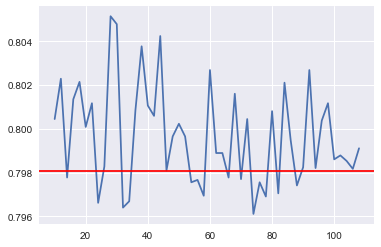

In [60]:
##Keras. Calculating number of features
llista = features_corr
initial_amount = 10
increases = 2
compte = []
accuracy_keras = []
X = data[llista]
y = data['No-show']
#intents = round(len(valid_features)/(len(valid_features)/(num_tries)))

for i in range(initial_amount, len(llista), increases):
    
    colec = llista[0:i]
    X= data[colec]
    #Xk = X.iloc[:, select.get_support()]
    compte.append(i)
    y = data['No-show']
    y = y.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.fit_transform(X_test)
    
  
    model = Sequential()

    model.add(Dense(Xs_train.shape[1], input_dim=Xs_train.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(Xs_train, y_train, validation_data=(Xs_test, y_test), epochs=10)  
    model.predict(Xs_test)
    pred = model.predict_classes(Xs_test)
    predicted = pred[:,0]
    acc = accuracy_score(y_test, predicted)
    pred[:,0]
    accuracy_keras.append(acc)
    

        

plt.plot(compte, accuracy_keras)
plt.axhline(baseline, c='r')

In [64]:
with open('accuracy_keras.pkl', 'wb') as picklefile:
    pickle.dump(accuracy_keras, picklefile)

In [66]:
with open('accuracy_keras.pkl', 'rb') as picklefile:
    the_same_sample = pickle.load(picklefile)

# Bernoulli NB

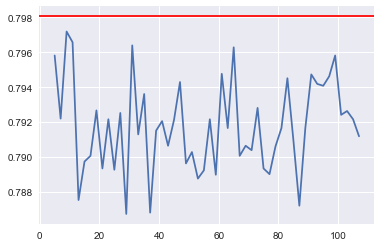

In [7]:
llista = valid_features
initial_amount = 5
increases = 2
compte = []
accuracy_BNB = []
X = data[valid_features]
y = data['No-show']
for i in range(initial_amount, len(llista), increases):
    select = SelectKBest(f_classif, k = i)
    select.fit(X, y)
    Xk = X.iloc[:, select.get_support()]
    compte.append(i)
    #intents = round(len(valid_features)/(len(valid_features)/(num_tries)))
    y = data['No-show']
    X_train, X_test, y_train, y_test = train_test_split(Xk,y)
    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.fit_transform(X_test)
    model = BernoulliNB()
    model.fit(X_train, y_train)
    model.score(X_test, y_test)
    predicted = model.predict(X_test)
    acc = accuracy_score(y_test, predicted)
    accuracy_BNB.append(acc)
plt.plot(compte, accuracy_BNB)
plt.axhline(baseline, c='r')

In [15]:
with open('accuracy_BNB.pkl', 'wb') as picklefile:
    pickle.dump(accuracy_BNB, picklefile)

# KNeighbors

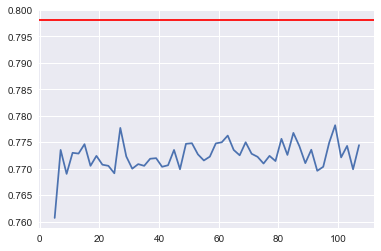

In [62]:
###KNN
llista = valid_features
initial_amount = 5
increases = 2
compte = []
accuracy_knn = []
X = data[valid_features]
y = data['No-show']
    #intents = round(len(valid_features)/(len(valid_features)/(num_tries)))
for i in range(initial_amount, len(llista), increases):
    select = SelectKBest(f_classif, k = i)
    select.fit(X, y)
    Xk = X.iloc[:, select.get_support()]
    compte.append(i)
    y = data['No-show']
    X_train, X_test, y_train, y_test = train_test_split(Xk,y)
    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.fit_transform(X_test)
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    model.score(X_test, y_test)
    predicted = model.predict(X_test)
    acc = accuracy_score(y_test, predicted)
    accuracy_knn.append(acc)
plt.plot(compte, accuracy_knn)
plt.axhline(baseline, c='r')

In [70]:
with open('accuracy_knn.pkl', 'wb') as picklefile:
    pickle.dump(accuracy_knn, picklefile)

# Support Vector Classifier

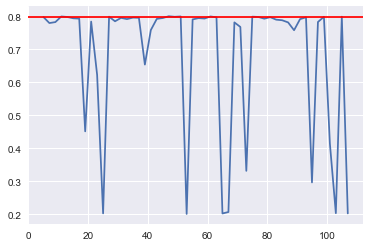

In [14]:
llista = valid_features
initial_amount = 5
increases = 2
compte = []
accuracy_svc = []
X = data[valid_features]
y = data['No-show']
    #intents = round(len(valid_features)/(len(valid_features)/(num_tries)))
for i in range(initial_amount, len(llista), increases):
    select = SelectKBest(f_classif, k = i)
    select.fit(X, y)
    Xk = X.iloc[:, select.get_support()]
    compte.append(i)
    y = data['No-show']
    X_train, X_test, y_train, y_test = train_test_split(Xk,y)
    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.fit_transform(X_test)
    model = LinearSVC()
    model.fit(X_train, y_train)
    model.score(X_test, y_test)
    predicted = model.predict(X_test)
    acc = accuracy_score(y_test, predicted)
    accuracy_svc.append(acc)
plt.plot(compte, accuracy_svc)
plt.axhline(baseline, c='r')

In [16]:
with open('accuracy_svc.pkl', 'wb') as picklefile:
    pickle.dump(accuracy_svc, picklefile)

# The winner is: GradienBoostClassifier